In [121]:
# TODO

# Ask Sarah about how editions are separated/duplicates. then, code this up for all editions
# Ask Sarah if we can see the real encyclopaedia?

# generate data always on cleaned up versions of text

# look through CW2 cleanup & code: what could be ported over
# for_later notes eg. \n clean

# DONE
# words/characters/volumes per edition
# run two_data & port re-format & visualisation from CW2
# save data in csv

In [17]:
import pandas as pd
import numpy as np
import re
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import csv
%matplotlib inline

In [18]:
# reading in index file

inventory = pd.read_csv("encyclopaediaBritannica-inventory.csv", header=None)
inventory.columns = ['file','volume']
# print(inventory)
print("\nNumber of text files: " + str(len(inventory)))


Number of text files: 195


In [19]:
first_ed = inventory[:3]
list(first_ed['volume']) # list() to print whole text

['Encyclopaedia Britannica; or, A dictionary of arts and sciences, compiled upon a new plan … - First edition, 1771, Volume 1, A-B - EB.1',
 'Encyclopaedia Britannica; or, A dictionary of arts and sciences, compiled upon a new plan … - First edition, 1771, Volume 2, C-L - EB.1',
 'Encyclopaedia Britannica; or, A dictionary of arts and sciences, compiled upon a new plan … - First edition, 1771, Volume 3, M-Z - EB.1']

In [20]:
second_ed = inventory[6:16]
list(second_ed['volume']) # list() to print whole text

['Encyclopaedia Britannica - Second edition, Volume 1, A-AST - EB.4',
 'Encyclopaedia Britannica - Second edition, Volume 2, Astronomy-BZO - EB.4',
 'Encyclopaedia Britannica - Second edition, Volume 3, C - EB.4',
 'Encyclopaedia Britannica - Second edition, Volume 4, D-F - EB.4',
 'Encyclopaedia Britannica - Second edition, Volume 5, G-J - EB.4',
 'Encyclopaedia Britannica - Second edition, Volume 6, K-Medicine - EB.4',
 'Encyclopaedia Britannica - Second edition, Volume 7, Medicines-Optics - EB.4',
 'Encyclopaedia Britannica - Second edition, Volume 8, Optics-Poetry - EB.4',
 'Encyclopaedia Britannica - Second edition, Volume 9, POI-SCU - EB.4',
 'Encyclopaedia Britannica - Second edition, Volume 10, SCU-Appendix - EB.4']

In [21]:
two_editions = [first_ed, second_ed]

In [22]:
# Reading in text files and generate volume, word and length counts

def basic_data(editions):
    
    data = []
    
    for ed in editions: 
        length = 0
        words = 0
        volumes = 0

        for index, row in ed.iterrows():
            print("Reading: " + row['file'])

            f = open('text/' + row['file'], 'r', encoding="utf8")
            content = f.read()
            content = clean_up(content)
            length += len(content)
            volumes += 1

            words += len(content.split())

            f.close()
            
        data.append([volumes, length, words])
        data_df=pd.DataFrame(data,columns=['volumes', 'length_chars','length_words'])
    return data_df

In [23]:
basic_df = basic_data(two_editions)
basic_df

Reading: 144133901.txt
Reading: 144133902.txt
Reading: 144133903.txt
Reading: 144850370.txt
Reading: 144850373.txt
Reading: 144850374.txt
Reading: 144850375.txt
Reading: 144850376.txt
Reading: 144850377.txt
Reading: 144850378.txt
Reading: 144850379.txt
Reading: 190273289.txt
Reading: 190273290.txt


,volumes,length_chars,length_words
0,3,14223433,2567769
1,10,56865594,10173856


In [12]:
basic_df.to_csv('csv/basic_data.csv')

In [13]:
basic_reimport = pd.read_csv('csv/basic_data.csv')
print(basic_reimport)

   Unnamed: 0  volumes  length_chars  length_words
0           0        3      14223433       2567769
1           1       10      56865594      10173856


## Most referenced topics

### Helper functions

#### For cleanup

In [24]:
def replace_by(s, a, b):
    """ perform a regex replacement, prints number of occurrences found and returns a string.
    s: string to make changes in
    a: string to remove 
    b: string to add
    returns: a string"""
    
    # print("Replacing \"" + a + "\" by \"" + b + "\", found " + str(len(re.findall(a, s))) + "...")
    new = re.sub(a, b, s)
    
    return new

In [25]:
# Using regex cleanup ideas from: https://sites.temple.edu/tudsc/2014/08/12/text-scrubbing-hacks-cleaning-your-ocred-text/

# Further resources: https://programminghistorian.org/en/lessons/cleaning-ocrd-text-with-regular-expressions
# https://datascience.stackexchange.com/questions/20536/how-to-improve-ocr-scanning-results

def clean_up(s):
    """ Does a minimal cleanup of a string of text
    returns: a string
    """
    # print("Initial length: " + str(len(s)))
    s2 = replace_by(s, 'tbe', 'the')
    s3 = replace_by(s2, 'tiie', 'the')
    s4 = replace_by(s3, 'liis', 'his')
    s5 = replace_by(s4, 'bis', 'his')
    s6 = replace_by(s5, '■', '')
    s7 = replace_by(s6, 'ib','in') # was noticed by Ava in .txt files
    s8 = replace_by(s7, '¬','')
    s9 = replace_by(s8, '.(\.\.+)', '') # multiple periods; what about ellipsis though?
    # print("Clean up done!")
    return s9 # CAREFUL to always pass the right one to next, and return

In [26]:
# This uses the list of header/definition/refs dataframes for each edition
# Check that this doesn't just do a reference replace, actually changes editions that are passed to it

def clean_up_definitions(editions):
    editions_cleaned = []
    for ed in editions:
        # realistically, a definition can't be shorter than 5 letters, even if it is simply a redirection of the form of "See x"
        ed = ed.loc[ed['def_length'] > 5]
        # remove headers with two letters as they are probably mostly noise
        ed = ed.loc[ed['header_length'] > 2]
        # remove headers longer than 40 characters, as these are likely to be noise
        ed = ed.loc[ed['header_length'] < 40]
        
        # We might also want to drop header duplicates, as each entry is only defined once
        # A good portion of these duplicates are probably noise (such as annotations in roman numerals)
        # We're not selecting the correct definition out of the duplicates here, just dropping them for the sake of simplicity
        ed.drop_duplicates(subset ="headers", keep = False, inplace = True)
        
        editions_cleaned.append(ed)
        
    return editions_cleaned

#### For extracting words and their definitions, and references ("See x")

In [27]:
# Uses RegEx to identify the definition of a word as being the content between the uppercase word and the next uppercase word

def find_definition(word, volume):
    start = re.search(word, volume).start()
    start_next = re.search(word, volume).end()
    
    second_word = re.search("[A-Z][A-Z]+", volume[start_next:])
    
    if second_word: # checking that second capitalised word exists (prevents NoneType exception)
        end = re.search("[A-Z][A-Z]+", volume[start_next:]).start()
        return volume[start_next+2:start_next+end] # +2 to ignore comma and space before a definition
    else:
        return ""

In [28]:
# Extracts entries (headers), their definitions, their respective lengths, and all references ("See x") from an edition

def extract_info(edition):
    
    headers = []
    definitions = []
    refs = [] # for counting up all instances of "See x" in volumes  
    
    for index, row in edition.iterrows():
        current_headers = []
        
        print("Reading: " + row['file'])
        f = open('text/' + row['file'], 'r', encoding="utf8")
        content = f.read()
        content = clean_up(content) # check cleanup does something
        # using https://stackoverflow.com/questions/9525993/get-consecutive-capitalized-words-using-regex
        # note: this ReGex is not entirely correct, as the first will select "MARTIAL" and "LAW"
        # "MARTIAL" will be cleaned out later due to having an empty definition, but "LAW" will have duplicates
        
        current_headers = re.findall('[A-Z][A-Z]+', content) # at least two uppercase letters following each other
        current_headers += re.findall('([A-Z][A-Z]+(?=\s[A-Z])(?:\s[A-Z][A-Z]+)+)', content) # two or more uppercase words
        refs += re.findall('See [^,\.]*', content) # matches "See x" until a comma or a period
        
        for word in current_headers:
            definitions.append(find_definition(word, content))
            
        headers = headers + current_headers
        
        f.close()

    data = pd.DataFrame(headers, columns =['headers'])
    data['definition'] = definitions
    data['header_length']  = data['headers'].str.len()
    data['def_length']  = data['definition'].str.len()
    return data, refs

In [29]:
# Generates a list of dataframes with words and their definitions for each edition

def words_and_definitions(editions):
    
    all_edition_data = []
    all_references = []
    
    for ed in editions:
        edition_data, references = extract_info(ed)
        all_edition_data.append(edition_data)
        all_references.append(references)
    return all_edition_data, all_references

In [30]:
two_data, two_refs = words_and_definitions(two_editions)

Reading: 144133901.txt
Reading: 144133902.txt
Reading: 144133903.txt
Reading: 144850370.txt
Reading: 144850373.txt
Reading: 144850374.txt
Reading: 144850375.txt
Reading: 144850376.txt
Reading: 144850377.txt
Reading: 144850378.txt
Reading: 144850379.txt
Reading: 190273289.txt
Reading: 190273290.txt


In [117]:
two_data_cleaned = clean_up_definitions(two_data)

In [120]:
two_data_cleaned[0]

,headers,definition,header_length,def_length
34,UTILITY,ught to be the principal intention of every pu...,7,2268
38,AUTHORS,&c.\nviji\nHome on bl acking.\nJack’s conic fe...,7,1841
41,AABAM,"a term, among alchemifts, for lead,\n",5,36
42,AACH,the name of a town and river in Swabia. It is\...,4,93
43,AADE,"the name of two rivers, one in the country of\...",4,106
...,...,...,...,...
29871,WOOD COCK,"in ornithology. See Scolopax.\nWood louse, in ...",9,106
29872,WOT TON,"a market.town of Gloucefterfhire, fituated fe-...",7,82
29873,WYE\nWREATH,"in heraldry, a roll of fine linen or (ilk (lik...",10,222
29874,WRES FLING,a kind of combat or engagement between\ntwo pe...,10,178


In [119]:
two_data_cleaned[0].to_csv('csv/two_data_0.csv')
two_data_cleaned[1].to_csv('csv/two_data_1.csv')

In [109]:
with open("csv/two_refs.csv", "w", newline="") as f:
    writer = csv.writer(f)
    writer.writerows(two_refs)

In [110]:
def generate_ref_counts(refs):
    
    all_ref_counts = []
    
    for ref in refs:
        # Converting unique counts to a DataFrame for easy visualisation
        ref_df = pd.DataFrame(ref)
        ref_counts = ref_df[0].value_counts()
        ref_counts = pd.DataFrame(ref_counts)
        ref_counts['references'] = ref_counts.index
        ref_counts.columns = ['count', 'references']
#         ref_counts = ref_counts.reset_index(True)
        all_ref_counts.append(ref_counts)
    
    return all_ref_counts

In [111]:
temp = generate_ref_counts(two_refs)

In [112]:
temp[0]

,count,references
See Anatomy,321,See Anatomy
See Law,151,See Law
See Medicine,131,See Medicine
See Chemistry,119,See Chemistry
See Astronomy,112,See Astronomy
...,...,...
See Apamea,1,See Apamea
See next article,1,See next article
See Gem,1,See Gem
See Leu-\nCACANTHA,1,See Leu-\nCACANTHA


In [113]:
temp[0].loc[temp[0].references == "See Anatomy"]['count']

See Anatomy    321
Name: count, dtype: int64

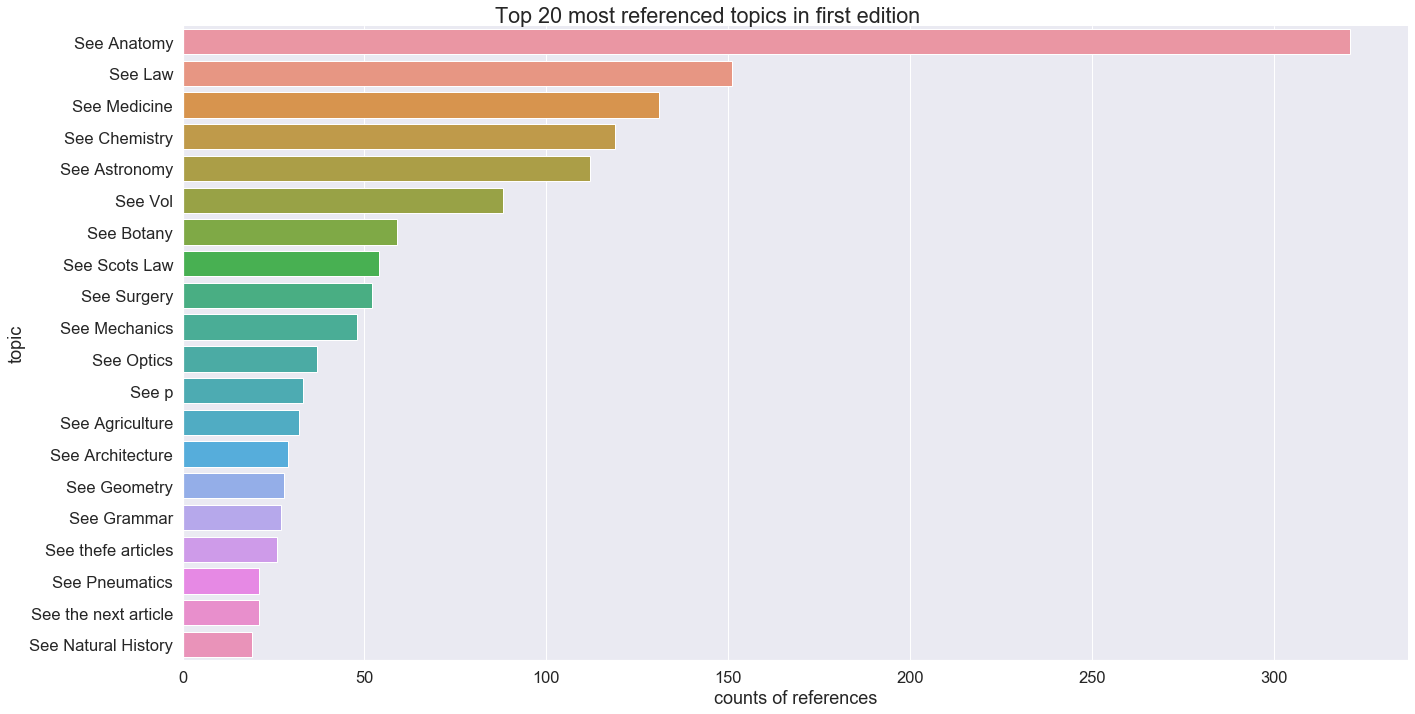

In [116]:
sns.set(font_scale=1.5)
ax = sns.catplot(x='count', y='references', data=temp[0].head(20), kind='bar', height=10, aspect=2)
ax.fig.suptitle("Top 20 most referenced topics in first edition", y=1)
ax.set_axis_labels('counts of references', 'topic')